# Task 3

Let's implement a Neural Network, which contains a stack of 2 LSTMs, both processing sequences, 2 Fully Connected layers and 1-3 Dropouts. You can use max. one additional convolutional layer, if needed. Let's use Sequential API, Adam optimizer and MNIST dataset. Use properly the train, val and test splits presented below. Your model should obtain at least 98.5% accuracy on both val and test sets. Then, let's implement the Grad-CAM algorithm to visualize a class activation heatmap (function get_gradcam_heatmap).

In [2]:
import numpy as np
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

11493376/11490434 [==============================] - 0s 0us/step


In [148]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv2D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

conv_filters_size = 8

model = Sequential()
model.add(Reshape((28,28,1), input_shape=(28,28)))
model.add(Conv2D(conv_filters_size, kernel_size=(3,3), padding='same', input_shape=(28,28, 1), name='first_CONV'))
model.add(Reshape((28,28 * conv_filters_size)))
model.add(LSTM(28, return_sequences=True, input_shape=(28, 28 * conv_filters_size), name='first_LSTM'))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dropout(0.2))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [163]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_36 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
first_CONV (Conv2D)          (None, 28, 28, 8)         80        
_________________________________________________________________
reshape_37 (Reshape)         (None, 28, 224)           0         
_________________________________________________________________
first_LSTM (LSTM)            (None, 28, 28)            28336     
_________________________________________________________________
dropout_72 (Dropout)         (None, 28, 28)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 200)               183200    
_________________________________________________________________
dropout_73 (Dropout)         (None, 200)             

In [150]:
model.fit(x_train,y_train, batch_size=128, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
391/391 [==============================] - 6s 11ms/step - loss: 0.8813 - accuracy: 0.6948 - val_loss: 0.1774 - val_accuracy: 0.9455
Epoch 2/30
391/391 [==============================] - 3s 9ms/step - loss: 0.1938 - accuracy: 0.9408 - val_loss: 0.1124 - val_accuracy: 0.9658
Epoch 3/30
391/391 [==============================] - 3s 8ms/step - loss: 0.1288 - accuracy: 0.9608 - val_loss: 0.0838 - val_accuracy: 0.9738
Epoch 4/30
391/391 [==============================] - 3s 8ms/step - loss: 0.1088 - accuracy: 0.9665 - val_loss: 0.1007 - val_accuracy: 0.9698
Epoch 5/30
391/391 [==============================] - 3s 8ms/step - loss: 0.1031 - accuracy: 0.9677 - val_loss: 0.0751 - val_accuracy: 0.9759
Epoch 6/30
391/391 [==============================] - 3s 8ms/step - loss: 0.0841 - accuracy: 0.9742 - val_loss: 0.0640 - val_accuracy: 0.9807
Epoch 7/30
391/391 [==============================] - 3s 8ms/step - loss: 0.0718 - accuracy: 0.9775 - val_loss: 0.0589 - val_accuracy: 0.9820
Epoch

In [165]:
model.evaluate(x_val, y_val)

313/313 [==============================] - 1s 4ms/step - loss: 0.0486 - accuracy: 0.9870


[0.04862743988633156, 0.9869999885559082]

In [166]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0441 - accuracy: 0.9881


[0.044090479612350464, 0.988099992275238]

In [169]:
import tensorflow as tf

NAME_OF_LAYER_FOR_CAM_GRAD = "first_CONV"

# source https://keras.io/examples/vision/grad_cam/

def get_heatmap( model, img ):
  img = np.expand_dims(img, 0)
  cam_grad_layer = model.get_layer(NAME_OF_LAYER_FOR_CAM_GRAD)
  cam_grad_layer_model = tf.keras.Model(model.inputs, cam_grad_layer.output)


  classifier_input = tf.keras.Input(shape=cam_grad_layer.output.shape[1:]) 

  x = classifier_input
  for layer in model.layers[model.layers.index(cam_grad_layer)+1:]:
      x = layer(x)
  classifier_model = tf.keras.Model(classifier_input, x)

  with tf.GradientTape() as tape:
    cam_grad_layer_output = cam_grad_layer_model(img)
    tape.watch(cam_grad_layer_output)
    preds = classifier_model(cam_grad_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

  grads = tape.gradient(top_class_channel, cam_grad_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

  cam_grad_layer_output = cam_grad_layer_output.numpy()[0]
  for i in range(pooled_grads.shape[-1]):
    cam_grad_layer_output[:, :, i] *= pooled_grads[i]
  heatmap = np.mean(cam_grad_layer_output, axis=-1)
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
  return heatmap

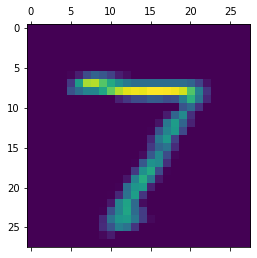

In [174]:
import matplotlib.pyplot as plt
heatmap = get_heatmap( model, x_test[0] )
plt.matshow(heatmap)
plt.show()

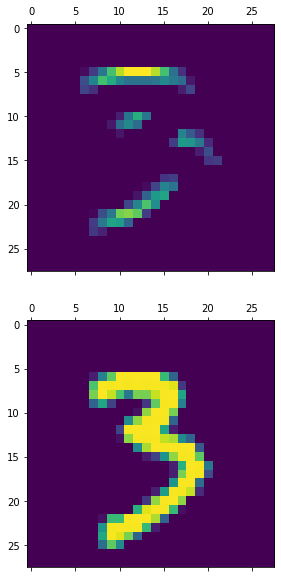

In [182]:
i = 30
f, ax = plt.subplots(2, figsize=(10,10))
ax[0].matshow(get_heatmap(model, x_test[i]))
ax[1].matshow(x_test[i])

plt.show()

## Save the trained model

In [164]:
model.save('result.h5', save_format='h5')

## Submission
You need to send by the deadline:
- the trained model with architecture and weights (as YourFirstName_YourSourname_Indeks.h5 file).
- and jupyter notebook (ipynb file) with all outputs and training logs (as YourFirstName_YourSourname_Indeks.ipynb file). The trained model should be reproducible by running Runtime -> Run all.